In [2]:
import requests
import io
import datetime

import numpy as np
import pandas as pd
import matplotlib.pylab as plt

In [4]:
from pykalman import KalmanFilter

In [5]:
INPUT_DIR = "input/"

In [6]:
df = pd.read_csv(INPUT_DIR + 'weekly.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

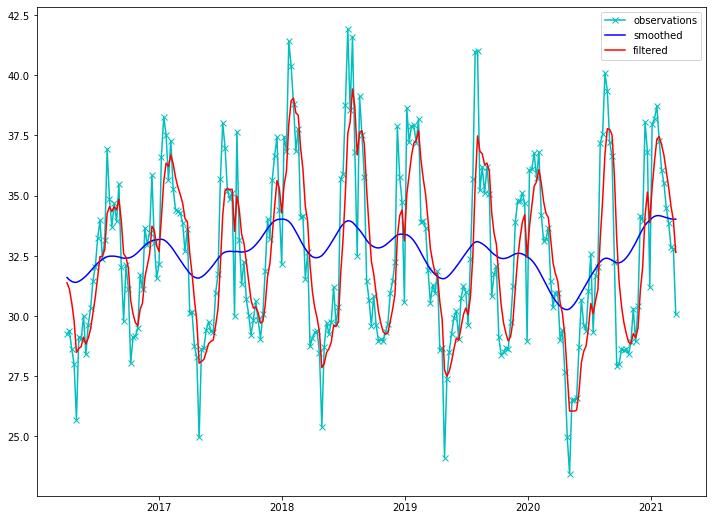

In [14]:
observations = df['power']

kf = KalmanFilter(transition_matrices=np.array([[1, 1], [0, 1]]),
                  transition_covariance=0.0000001*np.eye(2))

smoothed_states_pred = pd.Series(kf.em(observations).smooth(observations)[0][:, 0], index=df.index)
filtered_states_pred = pd.Series(kf.em(observations).filter(observations)[0][:, 0], index=df.index)

plt.figure(figsize=(12, 9))
plt.plot(observations, "-xc", label="observations")
plt.plot(smoothed_states_pred, "b", label="smoothed")
plt.plot(filtered_states_pred, "r", label="filtered")
# plt.axhline(x, color="k", label="truth value")
plt.legend()
plt.show()

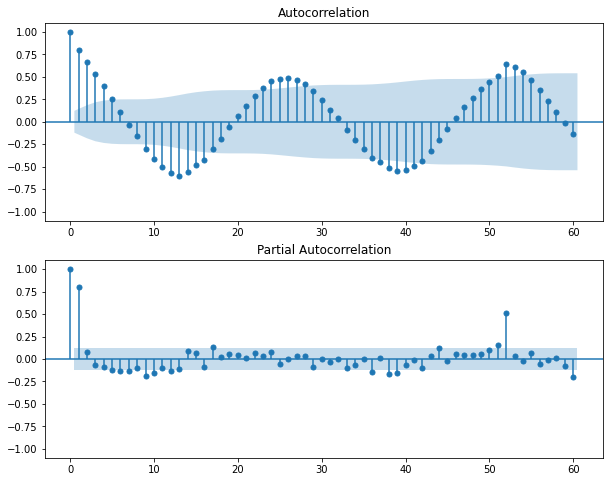

In [6]:
correlation_plot(df['power'])

/home/ryoji/.cache/pypoetry/virtualenvs/timeseries-weK0nu0g-py3.8/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


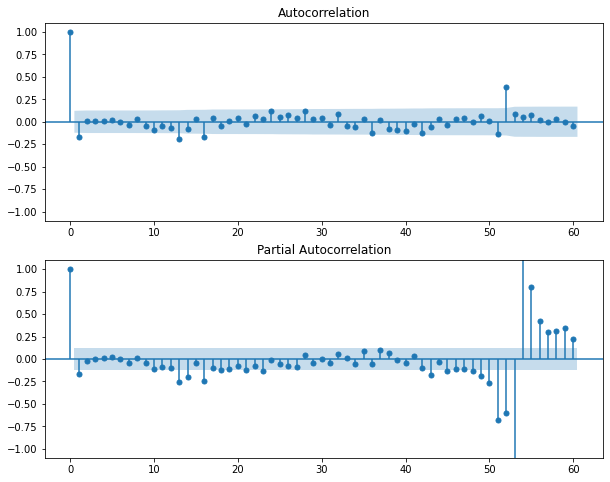

In [7]:
correlation_plot(df['power'].diff().dropna())

---ctt---
(-7.832096170959981, 8.547666676671152e-10, 12, 246, {'1%': -4.418850836053839, '5%': -3.856611247757094, '10%': -3.5682281566844916}, 1057.7017262653637)
---ct---
(-7.71743862191329, 3.213840577384215e-10, 12, 246, {'1%': -3.9960499911680953, '5%': -3.4284895182621864, '10%': -3.1376269313174987}, 1056.790548736114)
---c---
(-7.690178072754477, 1.4261593212952112e-11, 12, 246, {'1%': -3.457215237265747, '5%': -2.873361841566324, '10%': -2.5730700760129555}, 1055.8686466973559)
---nc---
(0.047235011079714166, 0.6997699522201957, 16, 242, {'1%': -2.5750407752202715, '5%': -1.942165172791115, '10%': -1.6157670321371942}, 1078.1442700499906)


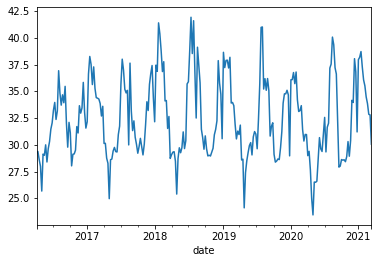

In [32]:
# 単位根過程であるかを検定。単位根過程（＝非定常過程）だとARを適用できない。
# p値が大きいと、単位根過程であることを棄却できない。すなわち、定常状態ではないと判断する。
y = df['power']
y.plot()
regs = ['ctt', 'ct', 'c', 'nc'] # 2次のトレンド＋定数項、1次のトレンド＋定数項, トレンドなし＋定数項、トレンド・定数項なし
for r in regs:
    print(f'---{r}---')
    print(sm.tsa.stattools.adfuller(y, regression=r))

---ctt---
(-7.935069094822518, 4.810467613439073e-10, 16, 241, {'1%': -4.419854389854461, '5%': -3.857118474113381, '10%': -3.5685407343243134}, 1075.2926461800816)
---ct---
(-7.964213170577016, 8.644620865880499e-11, 16, 241, {'1%': -3.9968337688702165, '5%': -3.4288662447936313, '10%': -3.1378478075975025}, 1073.4683443157974)
---c---
(-7.982396931623937, 2.602305429765183e-12, 16, 241, {'1%': -3.4577787098622674, '5%': -2.873608704758507, '10%': -2.573201765981991}, 1071.468590247262)
---nc---
(-8.003899084822473, 3.2146400659258724e-13, 16, 241, {'1%': -2.5750796256951496, '5%': -1.9421702285426112, '10%': -1.615762841121653}, 1069.4826010081863)


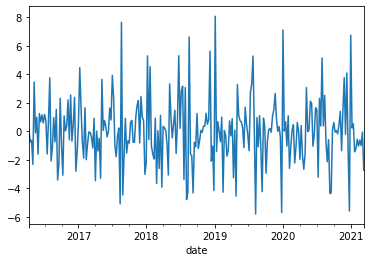

In [9]:
# トレンドはなさそうだが、定数項が無いことはなさそう。階差をとって定数項をなくす。
dy = df['power'].diff().dropna()
dy.plot()
regs = ['ctt', 'ct', 'c', 'nc'] # 2次のトレンド＋定数項、1次のトレンド＋定数項, トレンドなし＋定数項、トレンド・定数項なし
for r in regs:
    print(f'---{r}---')
    print(sm.tsa.stattools.adfuller(dy, regression=r))

Text(0, 0.5, 'Residual')

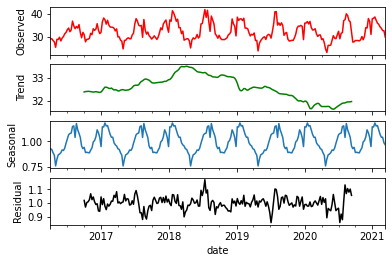

In [28]:
fig, axes = plt.subplots(4, 1, sharex=True)

decomposition = sm.tsa.seasonal_decompose(y, model ='multiplicative')
decomposition.observed.plot(ax=axes[0], legend=False, color='r')
axes[0].set_ylabel('Observed')
decomposition.trend.plot(ax=axes[1], legend=False, color='g')
axes[1].set_ylabel('Trend')
decomposition.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
decomposition.resid.plot(ax=axes[3], legend=False, color='k')
axes[3].set_ylabel('Residual')

Text(0, 0.5, 'Residual')

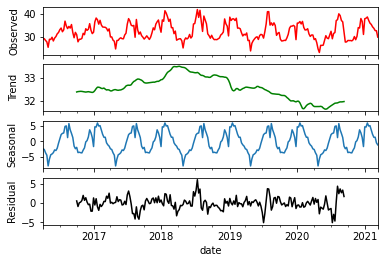

In [29]:
fig, axes = plt.subplots(4, 1, sharex=True)

decomposition = sm.tsa.seasonal_decompose(y, model ='additive')
decomposition.observed.plot(ax=axes[0], legend=False, color='r')
axes[0].set_ylabel('Observed')
decomposition.trend.plot(ax=axes[1], legend=False, color='g')
axes[1].set_ylabel('Trend')
decomposition.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
decomposition.resid.plot(ax=axes[3], legend=False, color='k')
axes[3].set_ylabel('Residual')

In [11]:
# 考えられるパラメータの組み合わせを全て作成
# 季節階差は52週
max_p = 2 #AR(自己回帰過程)の次数：いくつ前までの数字を回帰させるか
max_d = 1 #I（和分過程）の次数：原系列に対して何回差分を取るか
max_q = 1 #MA（移動平均過程）の次数：いくつ前までのノイズを回帰させるか
max_sp = 1 #季節階差のARの次数
max_sd = 1 #季節階差のIの次数
max_sq = 1 #季節階差のMAの次数
params = []

seasonal = 52

for p in range(0, max_p + 1):
    for d in range(0, max_d + 1): 
        for q in range(0, max_q + 1): 
            for sp in range(0, max_sp + 1):
                for sd in range(0, max_sd + 1): 
                    for sq in range(0, max_sq + 1): 
                        params.append([p,d,q,sp,sd,sq])

len(params)

96

In [12]:
# MAPEを計算する自作関数を定義
def calc_mape(true, pred):
    
    act = list(true)
    preds = list(pred)
    total = 0
    for i in range(len(act)):
        ape = np.abs((act[i] - preds[i])/act[i])
        total += ape
    mape = (total / len(act)) * 100
    
    return mape

In [13]:
# テストするため, 学習用とテスト用データの分割

test_start = datetime.datetime(2020, 1, 1)
test_end = datetime.datetime(2021, 1, 1)

cond_test = y.index >= test_start
cond_test &= y.index < test_end
y_test = y[cond_test]

cond_train = y.index < test_start
y_train = y[cond_train]

# AIC計算用のメソッドを作成
def aic_calculater(param):
    aic = sm.tsa.statespace.SARIMAX(endog=y_train, trend="n", order=(param[0], param[1], param[2]),
                                seasonal_order=(param[3], param[4], param[5], seasonal), 
                                enforce_invertibility = False, enforce_stationarity = False).fit().aic
    return aic
 
# 並列計算: n_jobs=-1とするとCPUコア数の数だけ並列化される
import joblib
aic_list = joblib.Parallel(n_jobs=-1, verbose=10)([joblib.delayed(aic_calculater)(param) for param in params])
 
# AICが小さくなる順にのパラメータの組み合わせを並べ変え
aic_df = pd.DataFrame({"params": params, "aic": aic_list})
aic_df.sort_values("aic", inplace=True)
aic_df.head(10)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done  91 out of  96 | elapsed:   18.7s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:   21.4s finished


,params,aic
59,"[1, 1, 1, 0, 1, 1]",367.030720
43,"[1, 0, 1, 0, 1, 1]",368.102732
91,"[2, 1, 1, 0, 1, 1]",369.057168
35,"[1, 0, 0, 0, 1, 1]",369.184345
75,"[2, 0, 1, 0, 1, 1]",370.080385
67,"[2, 0, 0, 0, 1, 1]",371.184329
11,"[0, 0, 1, 0, 1, 1]",374.828487
71,"[2, 0, 0, 1, 1, 1]",377.292268
63,"[1, 1, 1, 1, 1, 1]",377.333335
47,"[1, 0, 1, 1, 1, 1]",377.348775


In [14]:
# AICが最小のパラメータを当てはめる
best_params = aic_df.head(1)['params'].values[0]

model = sm.tsa.statespace.SARIMAX(endog=y_train, trend="n", order=(best_params[0], best_params[1], best_params[2]),
                                seasonal_order=(best_params[3], best_params[4], best_params[5], seasonal), 
                                enforce_invertibility = False, enforce_stationarity = False)
results = model.fit()

# テスト期間の予測値を出力する
y_pred = results.get_prediction(start = y_test.index[0], end = y_test.index[-1], dynamic=False)
 
# 点推定での予測値と区間推定での予測値を取り出す
pred_mean = y_pred.predicted_mean
pred_ci = y_pred.conf_int(alpha = .05)

# MAPEを算出
mape = calc_mape(y_test, pred_mean) 
print(mape)


/home/ryoji/.cache/pypoetry/virtualenvs/timeseries-weK0nu0g-py3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/home/ryoji/.cache/pypoetry/virtualenvs/timeseries-weK0nu0g-py3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/home/ryoji/.cache/pypoetry/virtualenvs/timeseries-weK0nu0g-py3.8/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


6.493883024449837


In [15]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              power   No. Observations:                  196
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 52)   Log Likelihood                -179.515
Date:                            Wed, 24 Mar 2021   AIC                            367.031
Time:                                    19:11:04   BIC                            376.985
Sample:                                04-04-2016   HQIC                           371.043
                                     - 12-30-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5690      0.093      6.103      0.000       0.386       0.752
ma.L1         -1.0177      0.050    -20.220      0.000      -1.116      -0.919
ma.S.L52      -1.0000   5961.888     -0.000      1.000   -1.17e+04    1.17e+04
sigma2         2.2177   1.32e+04      0.000      1.000   -2.59e+04    2.59e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.57
Prob(Q):                              0.95   Prob(JB):                         0.46
Heteroskedasticity (H):               1.42   Skew:                             0.26
Prob(H) (two-sided):                  0.34   Kurtosis:                         3.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

回帰係数のチェック
- ar.L1:一つ前の実績の半分にした値が影響している。
- ma.L1:一つ前の誤差のマイナスにしたものが影響している。
- ma.S.L52:一つ前の誤差のマイナスにしたものが影響している。が、信頼区間が広すぎる。
- sigma2 :信頼区間が広すぎる。

残差のチェック
- Jarque-Bera (JB):尖度と歪度による正規性の検定　H0は標本分布が正規分布に従う。
- Ljung-Box (L1) (Q)：H0　データは無作為（ラグと相関がないか）
- Heteroskedasticity (H):　H0　分散は均一である。

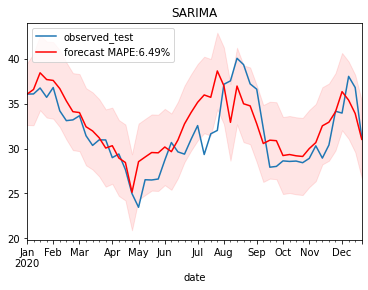

In [16]:
y_test.plot(label='observed_test')
pred_mean.plot(label=f'forecast MAPE:{mape:.2f}%', color = "r")
 
# 区間予測の折れ線グラフを描画
plt.title('SARIMA')
plt.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='r', alpha=.1)
plt.legend()
plt.show()

<AxesSubplot:xlabel='date'>

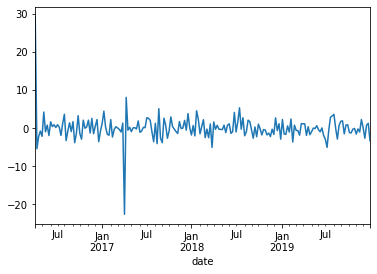

In [17]:
# GWの曜日のズレ？
results.resid.plot()

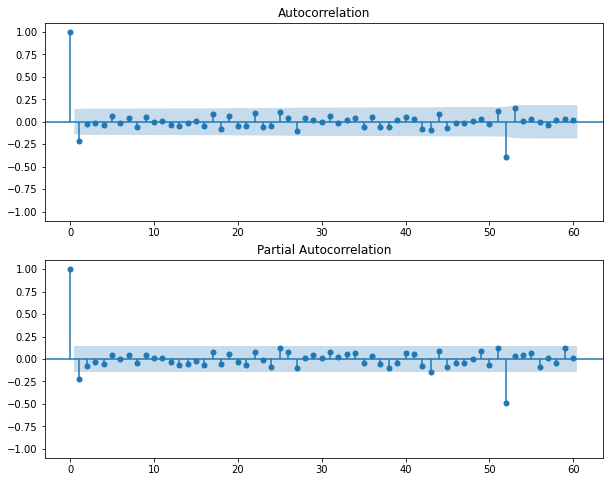

In [18]:
correlation_plot(results.resid)

## 外部変数として気温を追加

In [19]:
df_temperature = pd.read_csv(INPUT_DIR + 'weekly_temperature.csv')
df_temperature['date'] = pd.to_datetime(df_temperature['date'])
df_temperature = df_temperature.set_index('date')
df_temperature

,temperature,temperature_std
date,,
2016-04-04,15.028571,2.238090
2016-04-11,14.685714,2.928269
2016-04-18,16.771429,1.362246
2016-04-25,17.114286,1.722816
2016-05-02,20.371429,1.893598
...,...,...
2021-01-25,6.371429,2.211873
2021-02-01,7.871429,1.331308
2021-02-08,8.100000,2.610875


In [20]:
x = df_temperature['temperature']

In [21]:
cond_test = x.index >= test_start
cond_test &= x.index < test_end
x_test = x[cond_test]

cond_train = x.index < test_start
x_train = x[cond_train]

In [22]:
# AIC計算用のメソッドを作成
def aic_calculater(param):
    aic = sm.tsa.statespace.SARIMAX(
                                endog=y_train, exog=x_train, trend="n", order=(param[0], param[1], param[2]),
                                seasonal_order=(param[3], param[4], param[5], seasonal), 
        enforce_invertibility = False, enforce_stationarity = False).fit().aic
    return aic
 
# 並列計算: n_jobs=-1とするとCPUコア数の数だけ並列化される
import joblib
aic_list = joblib.Parallel(n_jobs=-1, verbose=10)([joblib.delayed(aic_calculater)(param) for param in params])
 
# AICが小さくなる順にのパラメータの組み合わせを並べ変え
aic_df = pd.DataFrame({"params": params, "aic": aic_list})
aic_df.sort_values("aic", inplace=True)
aic_df.head(10)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0490s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Batch computation too slow (4.9250s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done  91 out of  96 | elapsed:   28.8s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:   35.2s finished


,params,aic
59,"[1, 1, 1, 0, 1, 1]",364.570318
43,"[1, 0, 1, 0, 1, 1]",365.556844
91,"[2, 1, 1, 0, 1, 1]",366.491660
35,"[1, 0, 0, 0, 1, 1]",366.734062
75,"[2, 0, 1, 0, 1, 1]",367.082330
67,"[2, 0, 0, 0, 1, 1]",368.821352
63,"[1, 1, 1, 1, 1, 1]",371.444796
11,"[0, 0, 1, 0, 1, 1]",371.602446
71,"[2, 0, 0, 1, 1, 1]",371.894351
47,"[1, 0, 1, 1, 1, 1]",371.900400


In [23]:
# AICが最小のパラメータを当てはめる
best_params = aic_df.head(1)['params'].values[0]

model = sm.tsa.statespace.SARIMAX(
                                endog=y_train, exog=x_train, trend="n", order=(best_params[0], best_params[1], best_params[2]),
                                seasonal_order=(best_params[3], best_params[4], best_params[5], seasonal), 
    enforce_invertibility = False, enforce_stationarity = False)

results = model.fit()

# テスト期間の予測値を出力する
y_pred_temp = results.get_prediction(
                                start = y_test.index[0],
                                end = y_test.index[-1],
                                exog = x_test,
                                dynamic=False)
 
# 点推定での予測値と区間推定での予測値を取り出す
pred_mean_temp = y_pred_temp.predicted_mean
pred_ci_temp = y_pred_temp.conf_int(alpha = .05)

mape_temp = calc_mape(y_test, pred_mean_temp) 
print(mape_temp)

/home/ryoji/.cache/pypoetry/virtualenvs/timeseries-weK0nu0g-py3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/home/ryoji/.cache/pypoetry/virtualenvs/timeseries-weK0nu0g-py3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/home/ryoji/.cache/pypoetry/virtualenvs/timeseries-weK0nu0g-py3.8/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


6.193584356257991


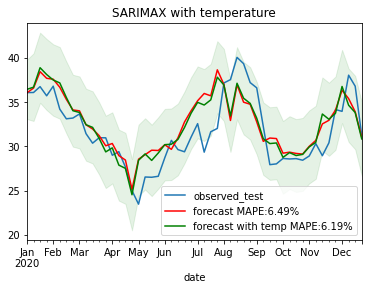

In [27]:
y_test.plot(label='observed_test')
pred_mean.plot(label=f'forecast MAPE:{mape:.2f}%', color = "r")
pred_mean_temp.plot(label=f'forecast with temp MAPE:{mape_temp:.2f}%', color = "g")

 
# 区間予測の折れ線グラフを描画
plt.title('SARIMAX with temperature')
plt.fill_between(pred_ci_temp.index, pred_ci_temp.iloc[:, 0], pred_ci_temp.iloc[:, 1], color='g', alpha=.1)
plt.legend()
plt.show()

<AxesSubplot:xlabel='date'>

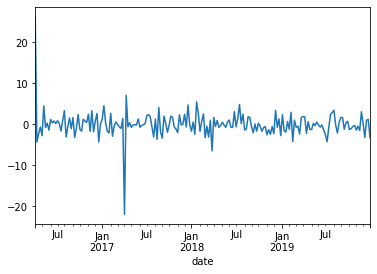

In [26]:
# GWの曜日のズレ？
results.resid.plot()

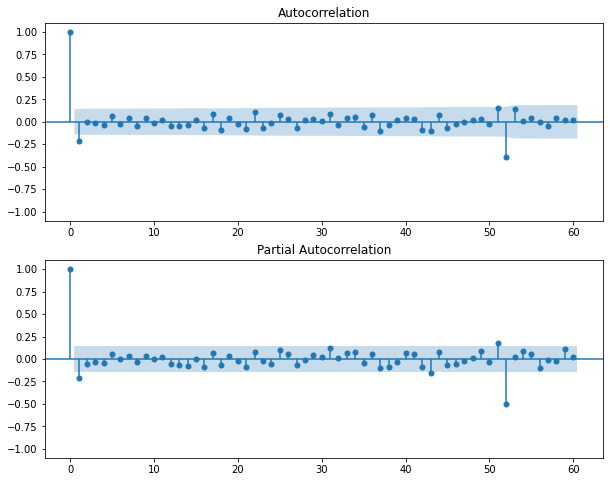

In [25]:
correlation_plot(results.resid)